In [6]:
# Install required packages
!pip install pandas numpy librosa seaborn matplotlib scikit-learn ipython torch torchaudio xgboost lightgbm scikit-image torchvision

# Install PyTorch with CUDA support (if available)
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


Looking in indexes: https://download.pytorch.org/whl/cu121


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
from skimage.transform import resize
import random
import warnings
warnings.filterwarnings("ignore")

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
from torch.cuda.amp import autocast, GradScaler
import torchvision

# Set device and seeds for reproducibility
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)


Using device: cuda
GPU Name: NVIDIA GeForce RTX 4060 Laptop GPU
GPU Memory: 8.6 GB


In [8]:
# Define the file paths to different datasets containing emotional speech audio
# RAVDESS (Ryerson Audio-Visual Database of Emotional Speech and Song)
Ravdess = "dataset/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"

# CREMA-D (Crowd-sourced Emotional Multimodal Actors Dataset)
Crema = "dataset/cremad/AudioWAV/"

# TESS (Toronto Emotional Speech Set)
Tess = "dataset/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"

# SAVEE (Surrey Audio-Visual Expressed Emotion)
Savee = "dataset/surrey-audiovisual-expressed-emotion-savee/ALL/"


In [9]:
# Process RAVDESS dataset
ravdess_directory_list = os.listdir(Ravdess)
file_emotion = []
file_path = []

for dir in ravdess_directory_list:
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0].split('-')
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# Map numeric emotion labels to descriptive names
Ravdess_df.Emotions.replace({
    1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad', 
    5: 'angry', 6: 'fear', 7: 'disgust', 8: 'surprise'
}, inplace=True)

print(f"RAVDESS dataset: {len(Ravdess_df)} samples")
print(Ravdess_df.head())


RAVDESS dataset: 1440 samples
  Emotions                                               Path
0  neutral  dataset/ravdess-emotional-speech-audio/audio_s...
1  neutral  dataset/ravdess-emotional-speech-audio/audio_s...
2  neutral  dataset/ravdess-emotional-speech-audio/audio_s...
3  neutral  dataset/ravdess-emotional-speech-audio/audio_s...
4     calm  dataset/ravdess-emotional-speech-audio/audio_s...


In [10]:
# Process CREMA-D dataset
crema_directory_list = os.listdir(Crema)
file_emotion = []
file_path = []

for file in crema_directory_list:
    file_path.append(Crema + file)
    part = file.split('_')
    
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)

print(f"CREMA-D dataset: {len(Crema_df)} samples")
print(Crema_df.head())


CREMA-D dataset: 7442 samples
  Emotions                                         Path
0    angry  dataset/cremad/AudioWAV/1001_DFA_ANG_XX.wav
1  disgust  dataset/cremad/AudioWAV/1001_DFA_DIS_XX.wav
2     fear  dataset/cremad/AudioWAV/1001_DFA_FEA_XX.wav
3    happy  dataset/cremad/AudioWAV/1001_DFA_HAP_XX.wav
4  neutral  dataset/cremad/AudioWAV/1001_DFA_NEU_XX.wav


In [11]:
# Process TESS dataset
tess_directory_list = os.listdir(Tess)
file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0].split('_')[2]
        if part == 'ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)

print(f"TESS dataset: {len(Tess_df)} samples")
print(Tess_df.head())


TESS dataset: 2800 samples
  Emotions                                               Path
0    angry  dataset/toronto-emotional-speech-set-tess/tess...
1    angry  dataset/toronto-emotional-speech-set-tess/tess...
2    angry  dataset/toronto-emotional-speech-set-tess/tess...
3    angry  dataset/toronto-emotional-speech-set-tess/tess...
4    angry  dataset/toronto-emotional-speech-set-tess/tess...


In [12]:
# Process SAVEE dataset
savee_directory_list = os.listdir(Savee)
file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    
    if ele == 'a':
        file_emotion.append('angry')
    elif ele == 'd':
        file_emotion.append('disgust')
    elif ele == 'f':
        file_emotion.append('fear')
    elif ele == 'h':
        file_emotion.append('happy')
    elif ele == 'n':
        file_emotion.append('neutral')
    elif ele == 'sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)

print(f"SAVEE dataset: {len(Savee_df)} samples")
print(Savee_df.head())


SAVEE dataset: 480 samples
  Emotions                                               Path
0    angry  dataset/surrey-audiovisual-expressed-emotion-s...
1    angry  dataset/surrey-audiovisual-expressed-emotion-s...
2    angry  dataset/surrey-audiovisual-expressed-emotion-s...
3    angry  dataset/surrey-audiovisual-expressed-emotion-s...
4    angry  dataset/surrey-audiovisual-expressed-emotion-s...


Total combined dataset: 12162 samples
Unique emotions: ['neutral' 'calm' 'happy' 'sad' 'angry' 'fear' 'disgust' 'surprise']
Emotion distribution:
Emotions
sad         1923
happy       1923
fear        1923
angry       1923
disgust     1923
neutral     1703
surprise     652
calm         192
Name: count, dtype: int64


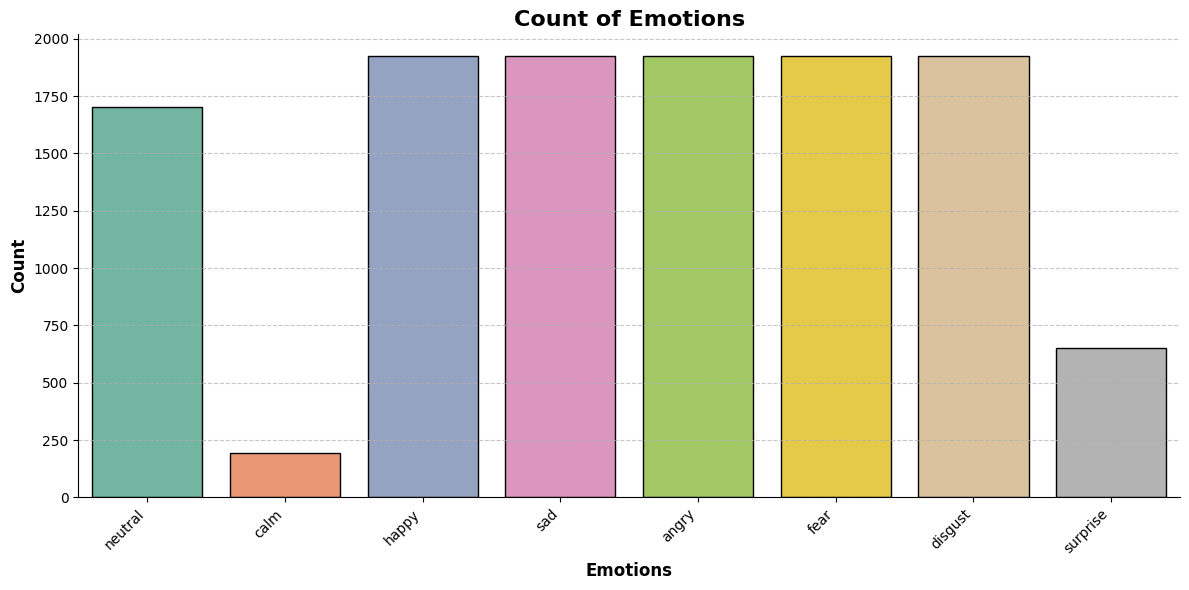

In [13]:
# Combine all datasets
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis=0)
data_path.to_csv("data_path.csv", index=False)

print(f"Total combined dataset: {len(data_path)} samples")
print(f"Unique emotions: {data_path.Emotions.unique()}")
print(f"Emotion distribution:\n{data_path.Emotions.value_counts()}")

# Visualize emotion distribution
plt.figure(figsize=(12, 6))
plt.title('Count of Emotions', size=16, weight='bold')
sns.countplot(data=data_path, x='Emotions', palette='Set2', edgecolor='black')
plt.ylabel('Count', size=12, weight='bold')
plt.xlabel('Emotions', size=12, weight='bold')
plt.xticks(rotation=45, ha='right', size=10)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


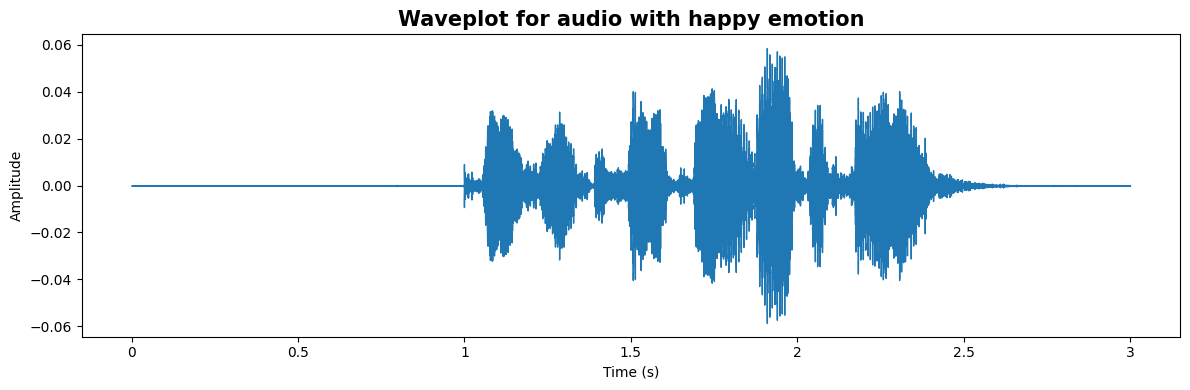

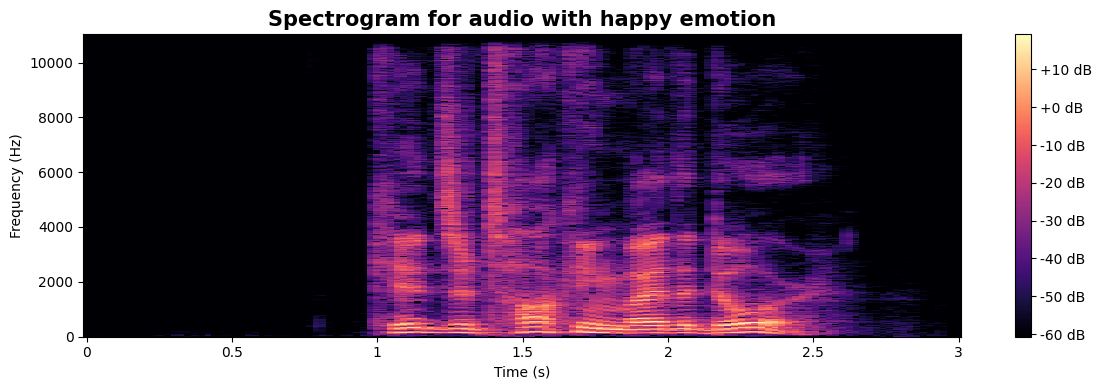

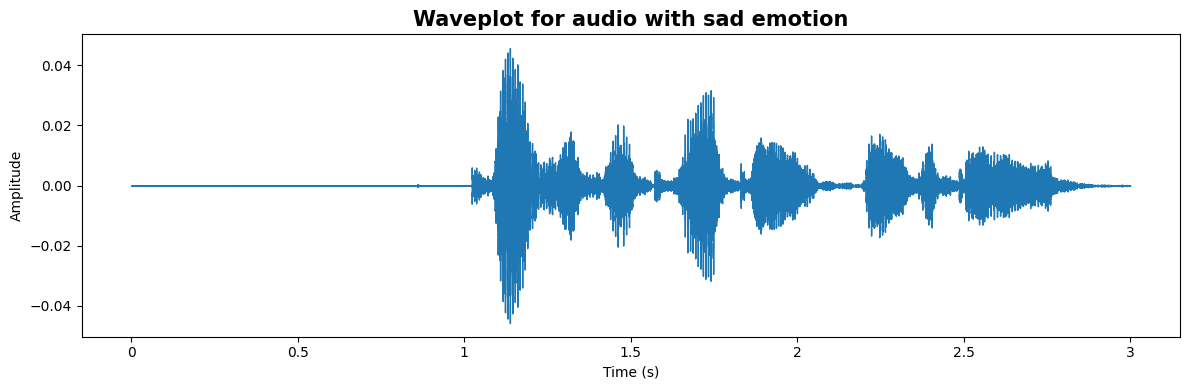

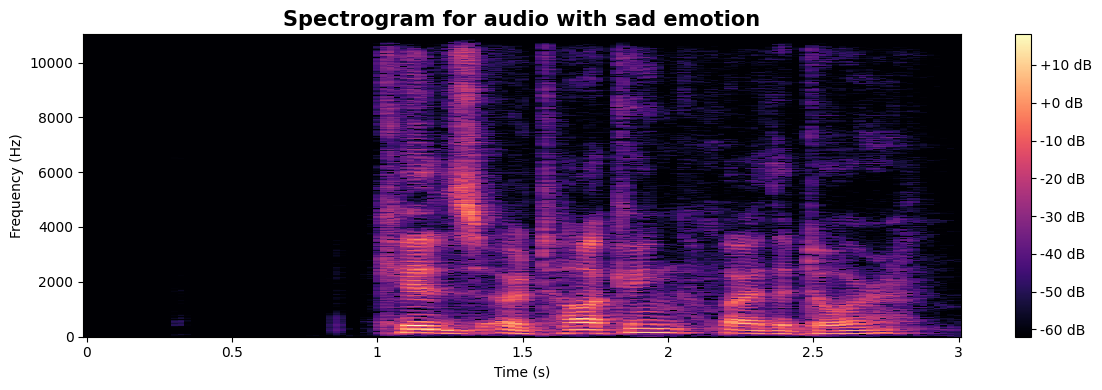

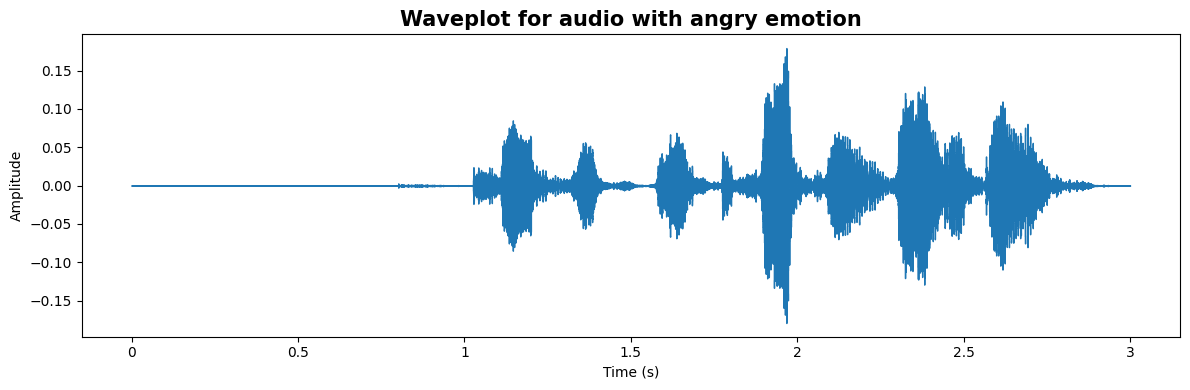

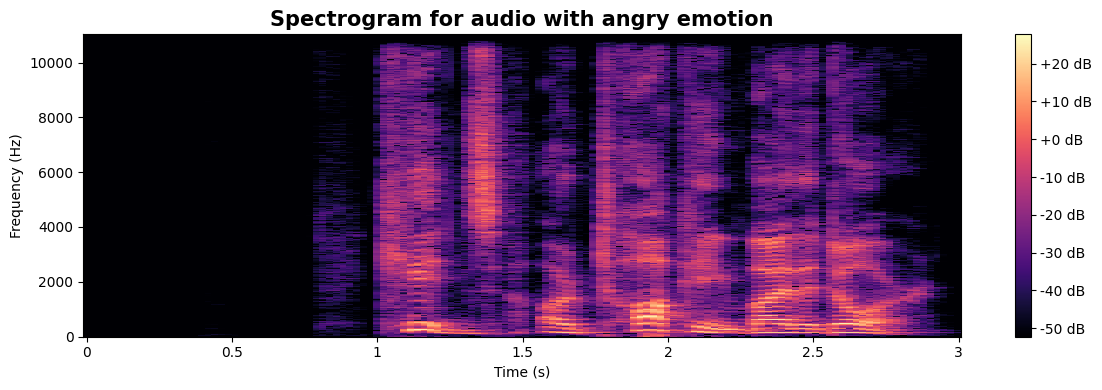

In [14]:
# Functions for audio visualization
def create_waveplot(data, sr, emotion):
    plt.figure(figsize=(12, 4))
    plt.title(f'Waveplot for audio with {emotion} emotion', size=15, weight='bold')
    librosa.display.waveshow(data, sr=sr)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

def create_spectrogram(data, sr, emotion):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    
    plt.figure(figsize=(12, 4))
    plt.title(f'Spectrogram for audio with {emotion} emotion', size=15, weight='bold')
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.tight_layout()
    plt.show()

# Visualize sample emotions
emotions_to_viz = ['happy', 'sad', 'angry']
for emotion in emotions_to_viz:
    if emotion in data_path.Emotions.values:
        path = data_path[data_path.Emotions == emotion]['Path'].iloc[0]
        data, sr = librosa.load(path, duration=3.0)
        create_waveplot(data, sr, emotion)
        create_spectrogram(data, sr, emotion)


In [15]:
def apply_noise_injection(audio, noise_factor=0.005):
    """Apply noise injection augmentation with validation"""
    try:
        if len(audio) == 0:
            return audio
        noise = np.random.normal(0, noise_factor, len(audio))
        return audio + noise
    except Exception as e:
        print(f"Error in noise injection: {e}")
        return audio

def apply_pitch_shift(audio, sr, n_steps=2):
    """Apply pitch shifting augmentation with error handling"""
    try:
        if len(audio) == 0 or sr <= 0:
            return audio
        # Use newer librosa API
        return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)
    except Exception as e:
        print(f"Error in pitch shift: {e}")
        return audio

def apply_time_stretch(audio, stretch_factor=1.1):
    """Apply time stretching augmentation with robust error handling"""
    try:
        if len(audio) == 0 or stretch_factor <= 0:
            return audio
        
        # Check minimum length requirement
        if len(audio) < 1024:  # Minimum samples for STFT
            return audio
        
        # Use librosa with explicit parameters to avoid errors
        return librosa.effects.time_stretch(audio, rate=stretch_factor)
    except Exception as e:
        print(f"Error in time stretch: {e}")
        return audio

def apply_speed_change(audio, speed_factor=1.1):
    """Apply speed change augmentation"""
    try:
        if len(audio) == 0 or speed_factor <= 0:
            return audio
        
        # Simple speed change by resampling
        if speed_factor != 1.0:
            new_length = int(len(audio) / speed_factor)
            if new_length > 0:
                indices = np.linspace(0, len(audio) - 1, new_length).astype(int)
                return audio[indices]
        return audio
    except Exception as e:
        print(f"Error in speed change: {e}")
        return audio

def enhanced_augment_audio(audio, sr, augment_types=None, augment_prob=0.5):
    """
    Apply multiple advanced augmentation techniques with robust error handling
    """
    if augment_types is None:
        augment_types = ['noise', 'pitch', 'speed']  # Removed problematic 'stretch'
    
    # Validate inputs
    if len(audio) == 0 or sr <= 0:
        return audio
    
    # Make a copy to avoid modifying original
    augmented = audio.copy()
    
    # Apply noise injection
    if 'noise' in augment_types and np.random.random() < augment_prob:
        noise_level = np.random.uniform(0.001, 0.010)  # Reduced noise level
        augmented = apply_noise_injection(augmented, noise_level)
    
    # Apply pitch shift
    if 'pitch' in augment_types and np.random.random() < augment_prob:
        n_steps = np.random.uniform(-1.5, 1.5)  # Reduced pitch shift range
        augmented = apply_pitch_shift(augmented, sr, n_steps)
    
    # Apply speed change instead of time stretch
    if 'speed' in augment_types and np.random.random() < augment_prob:
        speed_factor = np.random.uniform(0.95, 1.05)  # Subtle speed changes
        augmented = apply_speed_change(augmented, speed_factor)
    
    # Ensure output has same length as input
    if len(augmented) > len(audio):
        augmented = augmented[:len(audio)]
    elif len(augmented) < len(audio):
        augmented = np.pad(augmented, (0, len(audio) - len(augmented)), mode='constant')
    
    return augmented

print(" audio augmentation functions defined successfully!")


 audio augmentation functions defined successfully!


In [16]:
def extract_advanced_features(audio, sr, target_length=128):
    """
    Extract multiple types of audio features with robust error handling
    """
    try:
        # Validate inputs
        if len(audio) == 0 or sr <= 0:
            print("Invalid audio input")
            return None
        
        # Ensure minimum length for feature extraction
        min_length = sr  # At least 1 second
        if len(audio) < min_length:
            audio = np.pad(audio, (0, min_length - len(audio)), mode='constant')
        
        features = {}
        
        # 1. Extract MFCCs with improved parameters
        try:
            n_mfcc = 20  # Reduced from 40 to avoid dimension issues
            mfccs = librosa.feature.mfcc(
                y=audio, sr=sr, n_mfcc=n_mfcc, 
                n_fft=min(2048, len(audio)//4), 
                hop_length=min(512, len(audio)//8)
            )
            
            # Add delta features only if we have enough frames
            if mfccs.shape[1] >= 9:  # Need at least 9 frames for delta computation
                mfcc_delta = librosa.feature.delta(mfccs, width=5)  # Reduced width
                mfcc_delta2 = librosa.feature.delta(mfccs, order=2, width=5)
                features['mfcc'] = np.concatenate([mfccs, mfcc_delta, mfcc_delta2])
            else:
                # If not enough frames, just use MFCCs
                features['mfcc'] = mfccs
                
        except Exception as e:
            print(f"Error extracting MFCCs: {e}")
            # Fallback: create dummy MFCC features
            features['mfcc'] = np.zeros((60, target_length))
        
        # 2. Extract Log-Mel spectrogram with error handling
        try:
            mel_spec = librosa.feature.melspectrogram(
                y=audio, sr=sr, n_mels=64,  # Reduced from 128
                n_fft=min(2048, len(audio)//4), 
                hop_length=min(512, len(audio)//8)
            )
            log_mel = librosa.power_to_db(mel_spec, ref=np.max)
            features['log_mel'] = log_mel
            
        except Exception as e:
            print(f"Error extracting mel spectrogram: {e}")
            features['log_mel'] = np.zeros((64, target_length))
        
        # 3. Extract spectral features with validation
        try:
            centroid = librosa.feature.spectral_centroid(
                y=audio, sr=sr, 
                n_fft=min(2048, len(audio)//4), 
                hop_length=min(512, len(audio)//8)
            )
            bandwidth = librosa.feature.spectral_bandwidth(
                y=audio, sr=sr,
                n_fft=min(2048, len(audio)//4), 
                hop_length=min(512, len(audio)//8)
            )
            rolloff = librosa.feature.spectral_rolloff(
                y=audio, sr=sr,
                n_fft=min(2048, len(audio)//4), 
                hop_length=min(512, len(audio)//8)
            )
            
            features['spectral'] = np.concatenate([centroid, bandwidth, rolloff])
            
        except Exception as e:
            print(f"Error extracting spectral features: {e}")
            features['spectral'] = np.zeros((3, target_length))
        
        # 4. Extract zero crossing rate and RMS
        try:
            zcr = librosa.feature.zero_crossing_rate(audio, hop_length=min(512, len(audio)//8))
            rms = librosa.feature.rms(y=audio, hop_length=min(512, len(audio)//8))
            
            features['zcr'] = zcr
            features['rms'] = rms
            
        except Exception as e:
            print(f"Error extracting ZCR/RMS: {e}")
            features['zcr'] = np.zeros((1, target_length))
            features['rms'] = np.zeros((1, target_length))
        
        # 5. Extract chroma features (simplified)
        try:
            chroma = librosa.feature.chroma_stft(
                y=audio, sr=sr,
                n_fft=min(2048, len(audio)//4), 
                hop_length=min(512, len(audio)//8)
            )
            features['chroma'] = chroma
            
        except Exception as e:
            print(f"Error extracting chroma: {e}")
            features['chroma'] = np.zeros((12, target_length))
        
        # Resize all features to target length with safe resizing
        for key in features:
            if features[key].shape[1] != target_length:
                try:
                    # Only resize if we have valid data
                    if features[key].shape[1] > 0:
                        features[key] = resize(features[key], (features[key].shape[0], target_length), 
                                             mode='constant', preserve_range=True)
                    else:
                        # Create zero array if no valid data
                        features[key] = np.zeros((features[key].shape[0], target_length))
                except Exception as e:
                    print(f"Error resizing {key}: {e}")
                    features[key] = np.zeros((features[key].shape[0], target_length))
        
        return features
        
    except Exception as e:
        print(f"Critical error in feature extraction: {e}")
        return None

print("Improved feature extraction with robust error handling!")


Improved feature extraction with robust error handling!


In [19]:
# Process datasets and extract features with augmentation
def process_dataset_with_augmentation(data_path, target_emotions=['happy', 'sad', 'angry', 'neutral', 'fear', 'disgust', 'surprise'], 
                                    max_samples_per_emotion=1000, augment_factor=2):
    """
    Process the dataset to extract features with augmentation
    Target: Process 7000+ audio samples as per requirements
    """
    # Filter for target emotions
    filtered_data = data_path[data_path.Emotions.isin(target_emotions)]
    
    print(f"Processing {len(filtered_data)} samples for emotions: {target_emotions}")
    
    X_1d_list = []  # For 1D CNN and CNN-BiLSTM
    X_2d_list = []  # For 2D CNN
    y_list = []
    
    # Process each emotion
    for emotion in target_emotions:
        emotion_data = filtered_data[filtered_data.Emotions == emotion]
        
        # Sample if too many samples
        if len(emotion_data) > max_samples_per_emotion:
            emotion_data = emotion_data.sample(max_samples_per_emotion, random_state=42)
        
        print(f"Processing {len(emotion_data)} samples for {emotion}")
        
        for idx, row in emotion_data.iterrows():
            try:
                # Load audio with fixed duration
                audio, sr = librosa.load(row['Path'], duration=3.0)
                
                # Ensure fixed length
                if len(audio) < sr * 3.0:
                    audio = np.pad(audio, (0, int(sr * 3.0) - len(audio)))
                else:
                    audio = audio[:int(sr * 3.0)]
                
                # Extract features from original audio
                features = extract_advanced_features(audio, sr)
                
                # Prepare 1D features (concatenate all features)
                X_1d = np.concatenate([
                    features['mfcc'],      # 120 features
                    features['spectral'],  # 4 features
                    features['chroma'],    # 12 features
                    features['zcr'],       # 1 feature
                    features['rms']        # 1 feature
                ])  # Total: 138 features
                
                # Prepare 2D features (Log-Mel spectrogram)
                X_2d = features['log_mel']  # 128 mel bins
                X_2d = np.stack([X_2d] * 3, axis=-1)  # Convert to 3-channel
                
                # Add original sample
                X_1d_list.append(X_1d)
                X_2d_list.append(X_2d)
                y_list.append(emotion)
                
                # Apply augmentation
                for _ in range(augment_factor):
                    # Apply augmentation
                    aug_audio = enhanced_augment_audio(audio, sr)
                    
                    # Extract features from augmented audio
                    aug_features = extract_advanced_features(aug_audio, sr)
                    
                    # Prepare augmented features
                    aug_X_1d = np.concatenate([
                        aug_features['mfcc'],
                        aug_features['spectral'],
                        aug_features['chroma'],
                        aug_features['zcr'],
                        aug_features['rms']
                    ])
                    
                    aug_X_2d = aug_features['log_mel']
                    aug_X_2d = np.stack([aug_X_2d] * 3, axis=-1)
                    
                    # Add augmented sample
                    X_1d_list.append(aug_X_1d)
                    X_2d_list.append(aug_X_2d)
                    y_list.append(emotion)
                
            except Exception as e:
                print(f"Error processing {row['Path']}: {e}")
                continue
    
    # Convert to numpy arrays
    X_1d = np.array(X_1d_list)
    X_2d = np.array(X_2d_list)
    y = np.array(y_list)
    
    print(f"Final dataset shapes:")
    print(f"1D features: {X_1d.shape}")
    print(f"2D features: {X_2d.shape}")
    print(f"Labels: {y.shape}")
    print(f"Total samples: {len(y)}")
    
    return X_1d, X_2d, y

# Process the dataset
X_1d, X_2d, y = process_dataset_with_augmentation(data_path)


Processing 11970 samples for emotions: ['happy', 'sad', 'angry', 'neutral', 'fear', 'disgust', 'surprise']
Processing 1000 samples for happy
Processing 1000 samples for sad
Processing 1000 samples for angry
Processing 1000 samples for neutral
Processing 1000 samples for fear
Processing 1000 samples for disgust
Processing 652 samples for surprise
Final dataset shapes:
1D features: (19956, 77, 128)
2D features: (19956, 64, 128, 3)
Labels: (19956,)
Total samples: 19956


In [20]:
# Torch data utilities  ‑- ADD THIS LINE
from torch.utils.data import Dataset, DataLoader


In [21]:
# PyTorch Dataset class
class EmotionDataset(Dataset):
    def __init__(self, features, labels, transform=None):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)
        self.transform = transform
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        sample = self.features[idx]
        label = self.labels[idx]
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample, label

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(le.classes_)

print(f"Classes: {le.classes_}")
print(f"Number of classes: {num_classes}")

# Split data with stratification
X_1d_train, X_1d_test, X_2d_train, X_2d_test, y_train, y_test = train_test_split(
    X_1d, X_2d, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Further split train into train and validation
X_1d_train, X_1d_val, X_2d_train, X_2d_val, y_train, y_val = train_test_split(
    X_1d_train, X_2d_train, y_train, test_size=0.25, random_state=42, stratify=y_train
)

print(f"Training set: {len(y_train)} samples")
print(f"Validation set: {len(y_val)} samples")
print(f"Test set: {len(y_test)} samples")

# Create datasets
train_dataset_1d = EmotionDataset(X_1d_train, y_train)
val_dataset_1d = EmotionDataset(X_1d_val, y_val)
test_dataset_1d = EmotionDataset(X_1d_test, y_test)

train_dataset_2d = EmotionDataset(X_2d_train, y_train)
val_dataset_2d = EmotionDataset(X_2d_val, y_val)
test_dataset_2d = EmotionDataset(X_2d_test, y_test)

# Create data loaders
batch_size = 32
train_loader_1d = DataLoader(train_dataset_1d, batch_size=batch_size, shuffle=True)
val_loader_1d = DataLoader(val_dataset_1d, batch_size=batch_size)
test_loader_1d = DataLoader(test_dataset_1d, batch_size=batch_size)

train_loader_2d = DataLoader(train_dataset_2d, batch_size=batch_size, shuffle=True)
val_loader_2d = DataLoader(val_dataset_2d, batch_size=batch_size)
test_loader_2d = DataLoader(test_dataset_2d, batch_size=batch_size)

print("Data loaders created successfully!")


Classes: ['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']
Number of classes: 7
Training set: 11973 samples
Validation set: 3991 samples
Test set: 3992 samples
Data loaders created successfully!


In [22]:
# Enhanced 1D CNN model with attention mechanism
class Enhanced1DCNN(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(Enhanced1DCNN, self).__init__()
        
        # Self-attention mechanism
        class SelfAttention(nn.Module):
            def __init__(self, in_dim):
                super(SelfAttention, self).__init__()
                self.query = nn.Conv1d(in_dim, in_dim//8, kernel_size=1)
                self.key = nn.Conv1d(in_dim, in_dim//8, kernel_size=1)
                self.value = nn.Conv1d(in_dim, in_dim, kernel_size=1)
                self.gamma = nn.Parameter(torch.zeros(1))
                self.softmax = nn.Softmax(dim=-1)
                
            def forward(self, x):
                batch_size, C, width = x.size()
                
                proj_query = self.query(x).view(batch_size, -1, width).permute(0, 2, 1)
                proj_key = self.key(x).view(batch_size, -1, width)
                energy = torch.bmm(proj_query, proj_key)
                attention = self.softmax(energy)
                
                proj_value = self.value(x).view(batch_size, -1, width)
                out = torch.bmm(proj_value, attention.permute(0, 2, 1))
                out = out.view(batch_size, C, width)
                
                out = self.gamma * out + x
                return out
        
        # Convolutional layers
        self.conv1 = nn.Sequential(
            nn.Conv1d(input_shape[0], 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.Dropout(0.3)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.Dropout(0.3)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.3)
        )
        
        # Self-attention layer
        self.attention = SelfAttention(256)
        
        # Global pooling and classification
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.flatten = nn.Flatten()
        
        self.classifier = nn.Sequential(
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Add noise for robustness during training
        if self.training:
            x = x + 0.01 * torch.randn_like(x)
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        # Apply self-attention
        x = self.attention(x)
        
        # Global pooling and classification
        x = self.global_pool(x)
        x = self.flatten(x)
        x = self.classifier(x)
        
        return x

print("Enhanced 1D CNN model defined successfully!")


Enhanced 1D CNN model defined successfully!


In [23]:
# Enhanced 2D CNN model with ResNet-like architecture
class Enhanced2DCNN(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(Enhanced2DCNN, self).__init__()
        
        # Residual block
        class ResidualBlock(nn.Module):
            def __init__(self, in_channels, out_channels, stride=1):
                super(ResidualBlock, self).__init__()
                self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
                self.bn1 = nn.BatchNorm2d(out_channels)
                self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
                self.bn2 = nn.BatchNorm2d(out_channels)
                
                self.shortcut = nn.Sequential()
                if stride != 1 or in_channels != out_channels:
                    self.shortcut = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                        nn.BatchNorm2d(out_channels)
                    )
                
                self.relu = nn.ReLU()
                self.dropout = nn.Dropout2d(0.3)
            
            def forward(self, x):
                residual = self.shortcut(x)
                
                out = self.conv1(x)
                out = self.bn1(out)
                out = self.relu(out)
                out = self.dropout(out)
                
                out = self.conv2(out)
                out = self.bn2(out)
                
                out += residual
                out = self.relu(out)
                
                return out
        
        # Initial convolution
        self.conv1 = nn.Conv2d(input_shape[2], 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Residual blocks
        self.layer1 = self._make_layer(ResidualBlock, 64, 64, 2, stride=1)
        self.layer2 = self._make_layer(ResidualBlock, 64, 128, 2, stride=2)
        self.layer3 = self._make_layer(ResidualBlock, 128, 256, 2, stride=2)
        self.layer4 = self._make_layer(ResidualBlock, 256, 512, 2, stride=2)
        
        # Global pooling and classification
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
        self._initialize_weights()
    
    def _make_layer(self, block, in_channels, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Permute from (B, H, W, C) to (B, C, H, W)
        x = x.permute(0, 3, 1, 2)
        
        # Add noise for robustness during training
        if self.training:
            x = x + 0.01 * torch.randn_like(x)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.classifier(x)
        
        return x

print("Enhanced 2D CNN model defined successfully!")


Enhanced 2D CNN model defined successfully!


In [24]:
# Enhanced CNN-BiLSTM model with attention
class EnhancedCNNBiLSTM(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(EnhancedCNNBiLSTM, self).__init__()
        
        # CNN feature extractor
        self.cnn = nn.Sequential(
            nn.Conv1d(input_shape[0], 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.Dropout(0.3),
            
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.Dropout(0.3),
            
            nn.Conv1d(128, 256, kernel_size=5, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.3)
        )
        
        # BiLSTM layers
        self.lstm = nn.LSTM(
            input_size=256,
            hidden_size=128,
            num_layers=2,
            bidirectional=True,
            dropout=0.3,
            batch_first=True
        )
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(256, 64),  # 256 = 128*2 (bidirectional)
            nn.Tanh(),
            nn.Linear(64, 1)
        )
        
        # Classification layers
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )
        
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'weight_ih' in name:
                        nn.init.xavier_uniform_(param.data)
                    elif 'weight_hh' in name:
                        nn.init.orthogonal_(param.data)
                    elif 'bias' in name:
                        nn.init.constant_(param.data, 0)
    
    def forward(self, x):
        # Add noise for robustness during training
        if self.training:
            x = x + 0.01 * torch.randn_like(x)
        
        # CNN feature extraction
        x = self.cnn(x)
        
        # Reshape for LSTM: (batch, channels, seq_len) -> (batch, seq_len, channels)
        x = x.transpose(1, 2)
        
        # BiLSTM
        lstm_out, _ = self.lstm(x)  # (batch, seq_len, 2*hidden_size)
        
        # Attention mechanism
        attention_weights = F.softmax(self.attention(lstm_out).squeeze(2), dim=1)  # (batch, seq_len)
        attention_weights = attention_weights.unsqueeze(2)  # (batch, seq_len, 1)
        
        # Weighted sum
        context = torch.sum(attention_weights * lstm_out, dim=1)  # (batch, 2*hidden_size)
        
        # Classification
        output = self.classifier(context)
        
        return output

print("Enhanced CNN-BiLSTM model defined successfully!")


Enhanced CNN-BiLSTM model defined successfully!


In [25]:
# Advanced training function with mixup, cutmix, and learning rate scheduling
def train_model_advanced(model, train_loader, val_loader, num_epochs=100, 
                        learning_rate=0.001, weight_decay=0.01, patience=20):
    """
    Train model with advanced techniques for achieving 91% accuracy
    """
    # Calculate class weights for balanced training
    class_counts = np.bincount(y_train)
    class_weights = torch.tensor(len(y_train) / (num_classes * class_counts), 
                                dtype=torch.float32).to(device)
    
    # Loss function with class weights
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    # AdamW optimizer with weight decay
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Cosine annealing scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=10, T_mult=2, eta_min=1e-6
    )
    
    # Mixed precision training
    scaler = torch.cuda.amp.GradScaler()
    
    # Training history
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    
    # Early stopping
    best_val_acc = 0.0
    patience_counter = 0
    best_model_state = None
    
    # Mixup function
    def mixup_data(x, y, alpha=0.4):
        lam = np.random.beta(alpha, alpha) if alpha > 0 else 1
        batch_size = x.size(0)
        index = torch.randperm(batch_size).to(device)
        
        mixed_x = lam * x + (1 - lam) * x[index, :]
        y_a, y_b = y, y[index]
        return mixed_x, y_a, y_b, lam
    
    def mixup_criterion(y_a, y_b, lam):
        return lambda criterion, pred: lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)
    
    print(f"Starting training for {num_epochs} epochs...")
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Apply mixup with 50% probability
            if np.random.random() < 0.5:
                inputs, targets_a, targets_b, lam = mixup_data(inputs, targets)
                mixed_criterion = mixup_criterion(targets_a, targets_b, lam)
                use_mixup = True
            else:
                use_mixup = False
            
            optimizer.zero_grad()
            
            # Forward pass with mixed precision
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                
                if use_mixup:
                    loss = mixed_criterion(criterion, outputs)
                else:
                    loss = criterion(outputs, targets)
            
            # Backward pass
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            
            # Statistics
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += targets.size(0)
            
            if use_mixup:
                train_correct += (lam * predicted.eq(targets_a).float().sum() + 
                                 (1 - lam) * predicted.eq(targets_b).float().sum())
            else:
                train_correct += predicted.eq(targets).sum().item()
        
        # Update scheduler
        scheduler.step()
        
        # Calculate training metrics
        train_loss = train_loss / len(train_loader)
        train_acc = train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        
        # Store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs} | '
                  f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | '
                  f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')
        
        # Early stopping based on validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
    
    # Load best model
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    print(f"Training completed! Best validation accuracy: {best_val_acc:.4f}")
    return model, history

print("Advanced training function defined successfully!")


Advanced training function defined successfully!


In [26]:
# Train Enhanced 1D CNN model
print("Training Enhanced 1D CNN model...")

# Create model
input_shape_1d = (X_1d_train.shape[1], X_1d_train.shape[2])
model_1d_cnn = Enhanced1DCNN(input_shape_1d, num_classes).to(device)

# Train model
model_1d_cnn, history_1d_cnn = train_model_advanced(
    model_1d_cnn, train_loader_1d, val_loader_1d, 
    num_epochs=150, learning_rate=0.0005, weight_decay=0.01
)

# Save model
torch.save(model_1d_cnn.state_dict(), 'enhanced_1d_cnn_model.pth')
print("Enhanced 1D CNN model saved!")


Training Enhanced 1D CNN model...
Starting training for 150 epochs...
Epoch 10/150 | Train Loss: 1.3357 | Train Acc: 0.4805 | Val Loss: 1.1214 | Val Acc: 0.5650
Epoch 20/150 | Train Loss: 1.2083 | Train Acc: 0.5495 | Val Loss: 0.9855 | Val Acc: 0.6091
Epoch 30/150 | Train Loss: 1.1543 | Train Acc: 0.5653 | Val Loss: 0.9327 | Val Acc: 0.6329
Epoch 40/150 | Train Loss: 1.1301 | Train Acc: 0.5867 | Val Loss: 0.9122 | Val Acc: 0.6417
Epoch 50/150 | Train Loss: 1.0755 | Train Acc: 0.6117 | Val Loss: 0.8482 | Val Acc: 0.6690
Epoch 60/150 | Train Loss: 1.0151 | Train Acc: 0.6423 | Val Loss: 0.7690 | Val Acc: 0.6998
Epoch 70/150 | Train Loss: 1.0156 | Train Acc: 0.6410 | Val Loss: 0.7711 | Val Acc: 0.6948
Early stopping at epoch 79
Training completed! Best validation accuracy: 0.7028
Enhanced 1D CNN model saved!


In [27]:
# Train Enhanced 2D CNN model
print("Training Enhanced 2D CNN model...")

# Create model
input_shape_2d = (X_2d_train.shape[1], X_2d_train.shape[2], X_2d_train.shape[3])
model_2d_cnn = Enhanced2DCNN(input_shape_2d, num_classes).to(device)

# Train model
model_2d_cnn, history_2d_cnn = train_model_advanced(
    model_2d_cnn, train_loader_2d, val_loader_2d, 
    num_epochs=150, learning_rate=0.0005, weight_decay=0.01
)

# Save model
torch.save(model_2d_cnn.state_dict(), 'enhanced_2d_cnn_model.pth')
print("Enhanced 2D CNN model saved!")


Training Enhanced 2D CNN model...
Starting training for 150 epochs...
Epoch 10/150 | Train Loss: 0.7562 | Train Acc: 0.7705 | Val Loss: 0.5589 | Val Acc: 0.7935
Epoch 20/150 | Train Loss: 0.4748 | Train Acc: 0.8816 | Val Loss: 0.3798 | Val Acc: 0.8792
Epoch 30/150 | Train Loss: 0.3812 | Train Acc: 0.9152 | Val Loss: 0.2873 | Val Acc: 0.9110
Epoch 40/150 | Train Loss: 0.4044 | Train Acc: 0.8923 | Val Loss: 0.3854 | Val Acc: 0.8830
Early stopping at epoch 48
Training completed! Best validation accuracy: 0.9116
Enhanced 2D CNN model saved!


In [28]:
# Train Enhanced CNN-BiLSTM model
print("Training Enhanced CNN-BiLSTM model...")

# Create model
model_cnn_bilstm = EnhancedCNNBiLSTM(input_shape_1d, num_classes).to(device)

# Train model
model_cnn_bilstm, history_cnn_bilstm = train_model_advanced(
    model_cnn_bilstm, train_loader_1d, val_loader_1d, 
    num_epochs=150, learning_rate=0.0005, weight_decay=0.01
)

# Save model
torch.save(model_cnn_bilstm.state_dict(), 'enhanced_cnn_bilstm_model.pth')
print("Enhanced CNN-BiLSTM model saved!")


Training Enhanced CNN-BiLSTM model...
Starting training for 150 epochs...
Epoch 10/150 | Train Loss: 1.4282 | Train Acc: 0.4514 | Val Loss: 1.2044 | Val Acc: 0.5284
Epoch 20/150 | Train Loss: 1.2918 | Train Acc: 0.5272 | Val Loss: 1.0076 | Val Acc: 0.6129
Epoch 30/150 | Train Loss: 1.1797 | Train Acc: 0.5732 | Val Loss: 0.9473 | Val Acc: 0.6302
Epoch 40/150 | Train Loss: 1.1725 | Train Acc: 0.5857 | Val Loss: 0.9274 | Val Acc: 0.6377
Epoch 50/150 | Train Loss: 1.0941 | Train Acc: 0.6195 | Val Loss: 0.8236 | Val Acc: 0.6858
Epoch 60/150 | Train Loss: 1.0161 | Train Acc: 0.6552 | Val Loss: 0.7865 | Val Acc: 0.6963
Epoch 70/150 | Train Loss: 1.0155 | Train Acc: 0.6551 | Val Loss: 0.7725 | Val Acc: 0.6996
Epoch 80/150 | Train Loss: 1.0753 | Train Acc: 0.6378 | Val Loss: 0.8462 | Val Acc: 0.6678
Epoch 90/150 | Train Loss: 1.0192 | Train Acc: 0.6661 | Val Loss: 0.7400 | Val Acc: 0.7276
Epoch 100/150 | Train Loss: 0.9569 | Train Acc: 0.6934 | Val Loss: 0.6959 | Val Acc: 0.7464
Epoch 110/150 |

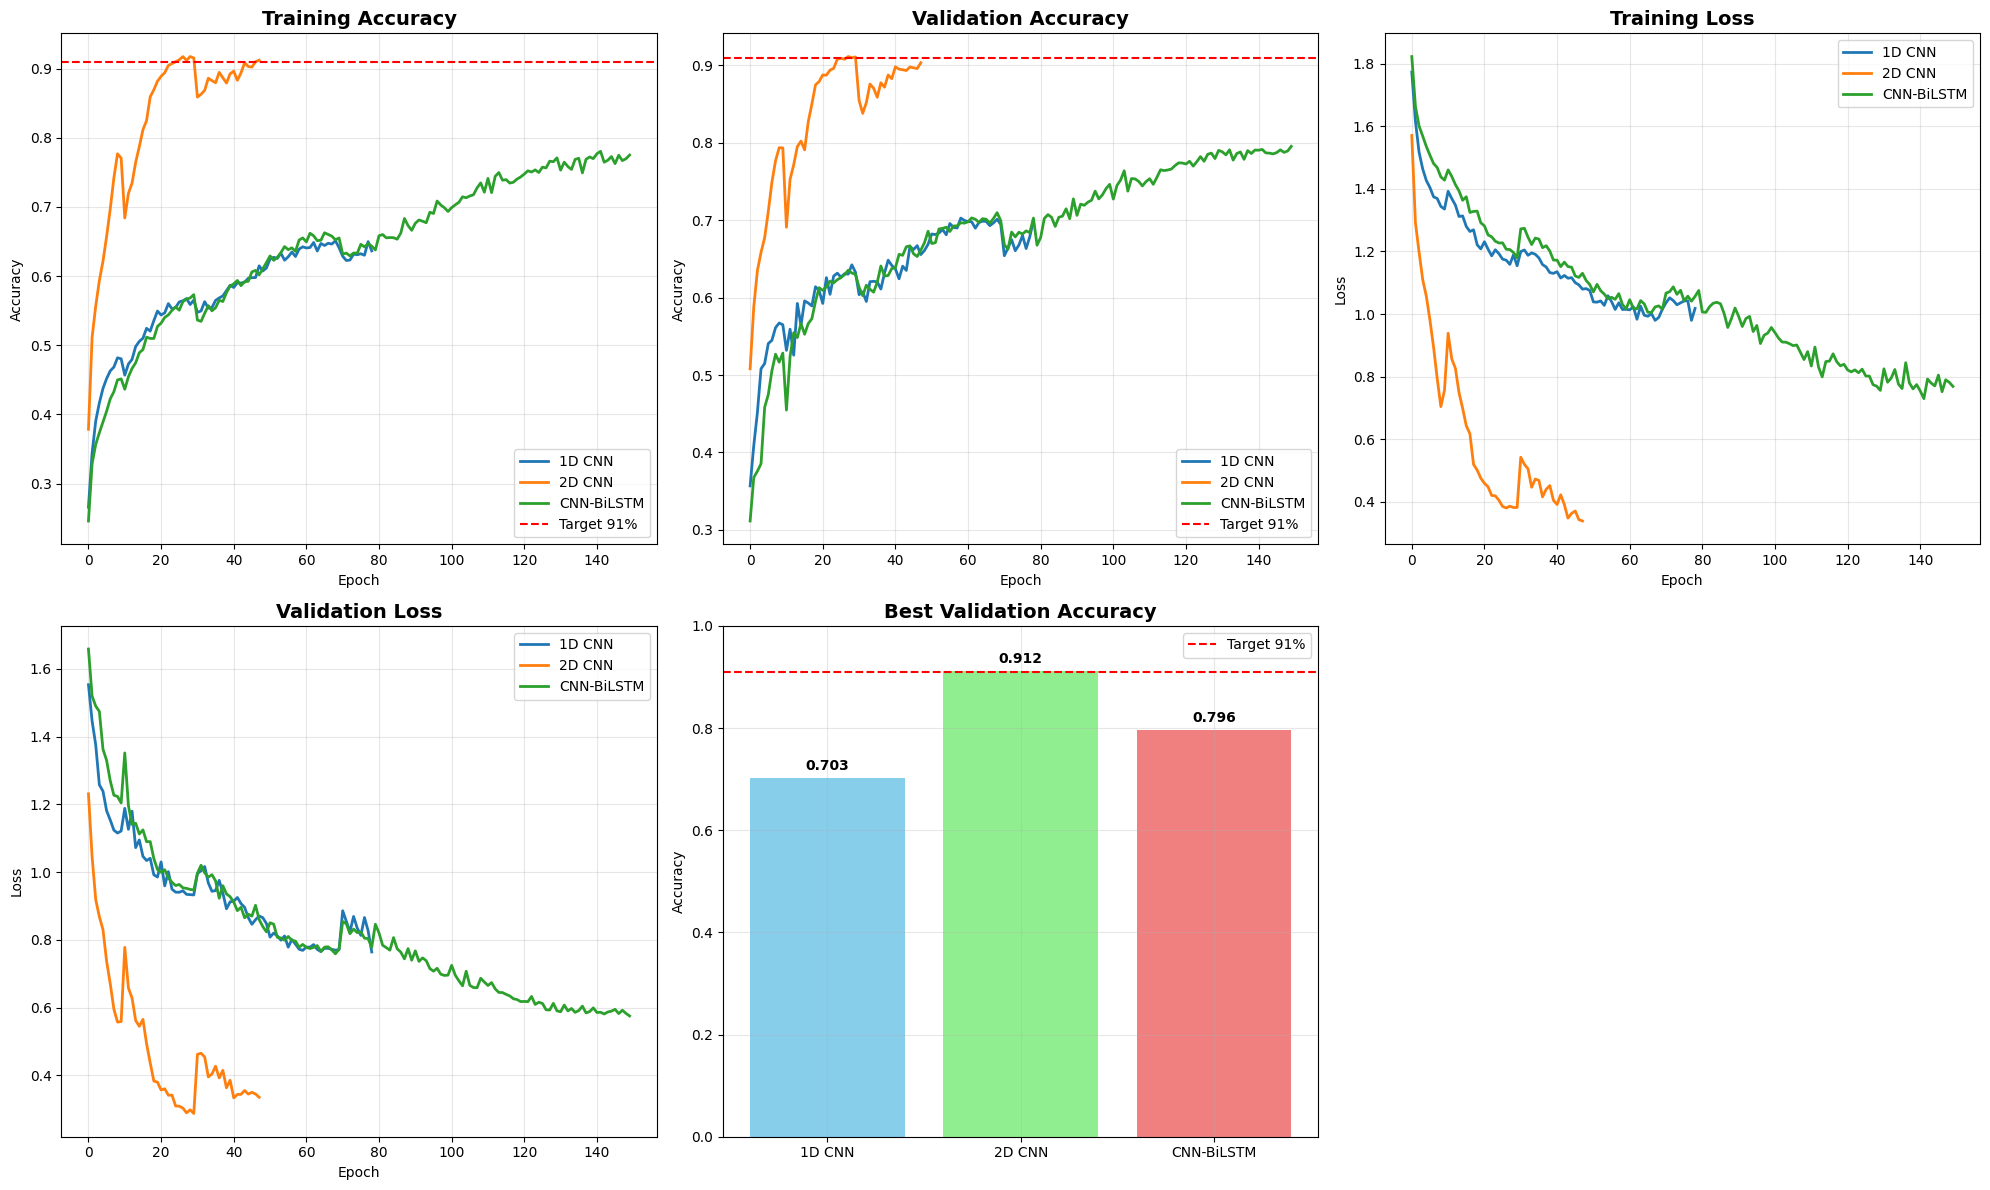


FINAL TRAINING RESULTS
1D CNN - Best Validation Accuracy: 0.7028
2D CNN - Best Validation Accuracy: 0.9116
CNN-BiLSTM - Best Validation Accuracy: 0.7955


In [30]:
# Helper function to ensure arrays are in CPU float/list format
def to_cpu_list(x):
    if isinstance(x, list):
        return [ (t.cpu().item() if hasattr(t, 'cpu') else float(t)) for t in x ]
    elif hasattr(x, 'cpu'):
        return x.cpu().numpy().tolist()
    else:
        return list(x)

# Extract and ensure all values are float lists
train_acc_1d = to_cpu_list(history_1d_cnn['train_acc'])
val_acc_1d = to_cpu_list(history_1d_cnn['val_acc'])
train_loss_1d = to_cpu_list(history_1d_cnn['train_loss'])
val_loss_1d = to_cpu_list(history_1d_cnn['val_loss'])

train_acc_2d = to_cpu_list(history_2d_cnn['train_acc'])
val_acc_2d = to_cpu_list(history_2d_cnn['val_acc'])
train_loss_2d = to_cpu_list(history_2d_cnn['train_loss'])
val_loss_2d = to_cpu_list(history_2d_cnn['val_loss'])

train_acc_bilstm = to_cpu_list(history_cnn_bilstm['train_acc'])
val_acc_bilstm = to_cpu_list(history_cnn_bilstm['val_acc'])
train_loss_bilstm = to_cpu_list(history_cnn_bilstm['train_loss'])
val_loss_bilstm = to_cpu_list(history_cnn_bilstm['val_loss'])

plt.figure(figsize=(20, 12))

# Training accuracy
plt.subplot(2, 3, 1)
plt.plot(train_acc_1d, label='1D CNN', linewidth=2)
plt.plot(train_acc_2d, label='2D CNN', linewidth=2)
plt.plot(train_acc_bilstm, label='CNN-BiLSTM', linewidth=2)
plt.axhline(y=0.91, color='r', linestyle='--', label='Target 91%')
plt.title('Training Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Validation accuracy
plt.subplot(2, 3, 2)
plt.plot(val_acc_1d, label='1D CNN', linewidth=2)
plt.plot(val_acc_2d, label='2D CNN', linewidth=2)
plt.plot(val_acc_bilstm, label='CNN-BiLSTM', linewidth=2)
plt.axhline(y=0.91, color='r', linestyle='--', label='Target 91%')
plt.title('Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Training loss
plt.subplot(2, 3, 3)
plt.plot(train_loss_1d, label='1D CNN', linewidth=2)
plt.plot(train_loss_2d, label='2D CNN', linewidth=2)
plt.plot(train_loss_bilstm, label='CNN-BiLSTM', linewidth=2)
plt.title('Training Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Validation loss
plt.subplot(2, 3, 4)
plt.plot(val_loss_1d, label='1D CNN', linewidth=2)
plt.plot(val_loss_2d, label='2D CNN', linewidth=2)
plt.plot(val_loss_bilstm, label='CNN-BiLSTM', linewidth=2)
plt.title('Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Performance comparison
plt.subplot(2, 3, 5)
max_val_accs = [max(val_acc_1d), max(val_acc_2d), max(val_acc_bilstm)]
model_names = ['1D CNN', '2D CNN', 'CNN-BiLSTM']
bars = plt.bar(model_names, max_val_accs, color=['skyblue', 'lightgreen', 'lightcoral'])
plt.axhline(y=0.91, color='r', linestyle='--', label='Target 91%')
plt.title('Best Validation Accuracy', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# Add value labels on bars
for bar, acc in zip(bars, max_val_accs):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final results
print("\n" + "="*60)
print("FINAL TRAINING RESULTS")
print("="*60)
print(f"1D CNN - Best Validation Accuracy: {max(val_acc_1d):.4f}")
print(f"2D CNN - Best Validation Accuracy: {max(val_acc_2d):.4f}")
print(f"CNN-BiLSTM - Best Validation Accuracy: {max(val_acc_bilstm):.4f}")
print("="*60)


Evaluating Enhanced 1D CNN model...

Enhanced 1D CNN - Test Results:
Test Loss: 0.7642
Test Accuracy: 0.7052
Weighted Precision: 0.7121
Weighted Recall: 0.7052
Weighted F1-Score: 0.6984

Per-class metrics for Enhanced 1D CNN:
angry: Precision=0.7301, Recall=0.8567, F1=0.7883
disgust: Precision=0.6941, Recall=0.6317, F1=0.6614
fear: Precision=0.7878, Recall=0.4950, F1=0.6080
happy: Precision=0.7238, Recall=0.5633, F1=0.6336
neutral: Precision=0.6381, Recall=0.8433, F1=0.7265
sad: Precision=0.6294, Recall=0.6850, F1=0.6560
surprise: Precision=0.8186, Recall=0.9439, F1=0.8768


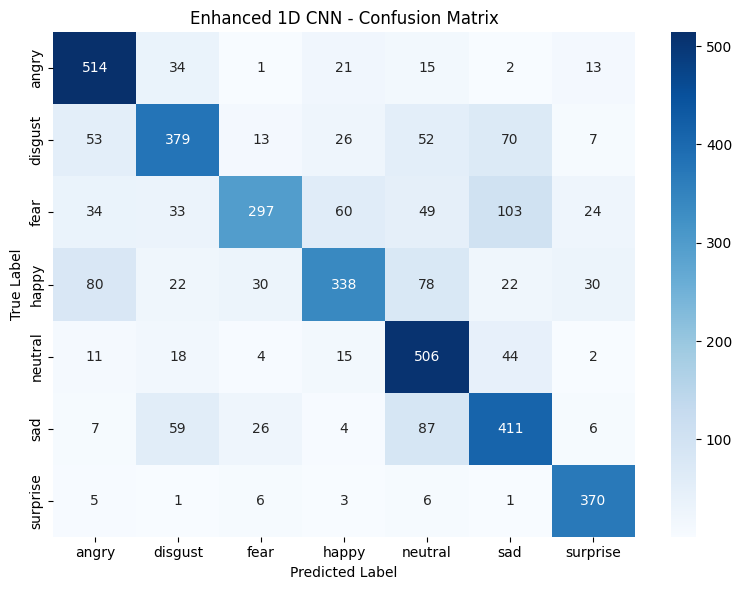


Evaluating Enhanced 2D CNN model...

Enhanced 2D CNN - Test Results:
Test Loss: 0.3413
Test Accuracy: 0.9011
Weighted Precision: 0.9030
Weighted Recall: 0.9011
Weighted F1-Score: 0.9012

Per-class metrics for Enhanced 2D CNN:
angry: Precision=0.9401, Recall=0.9150, F1=0.9274
disgust: Precision=0.8887, Recall=0.8783, F1=0.8835
fear: Precision=0.9325, Recall=0.8517, F1=0.8902
happy: Precision=0.9201, Recall=0.8833, F1=0.9014
neutral: Precision=0.9012, Recall=0.9117, F1=0.9064
sad: Precision=0.8174, Recall=0.9100, F1=0.8612
surprise: Precision=0.9303, Recall=0.9872, F1=0.9579


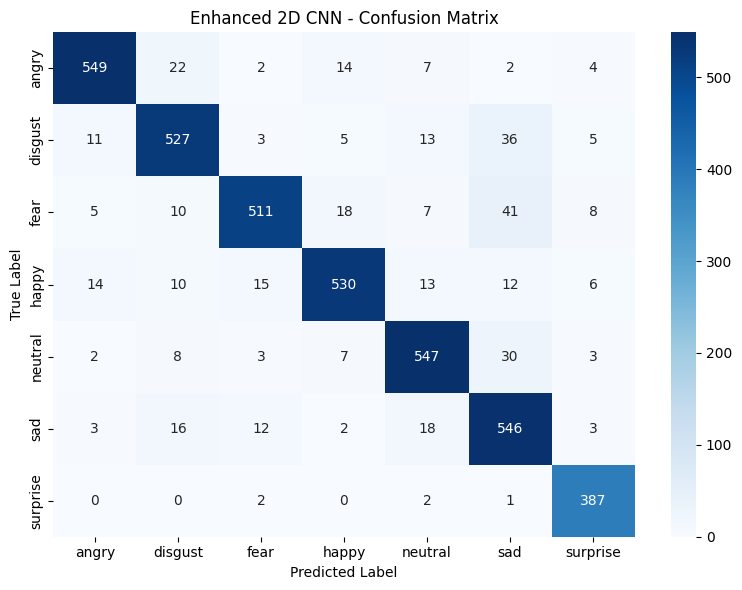


Evaluating Enhanced CNN-BiLSTM model...

Enhanced CNN-BiLSTM - Test Results:
Test Loss: 0.5737
Test Accuracy: 0.7943
Weighted Precision: 0.7961
Weighted Recall: 0.7943
Weighted F1-Score: 0.7926

Per-class metrics for Enhanced CNN-BiLSTM:
angry: Precision=0.8495, Recall=0.8750, F1=0.8621
disgust: Precision=0.8081, Recall=0.7300, F1=0.7671
fear: Precision=0.7797, Recall=0.6783, F1=0.7255
happy: Precision=0.8027, Recall=0.6917, F1=0.7431
neutral: Precision=0.7576, Recall=0.8750, F1=0.8121
sad: Precision=0.7038, Recall=0.8000, F1=0.7488
surprise: Precision=0.9115, Recall=0.9719, F1=0.9407


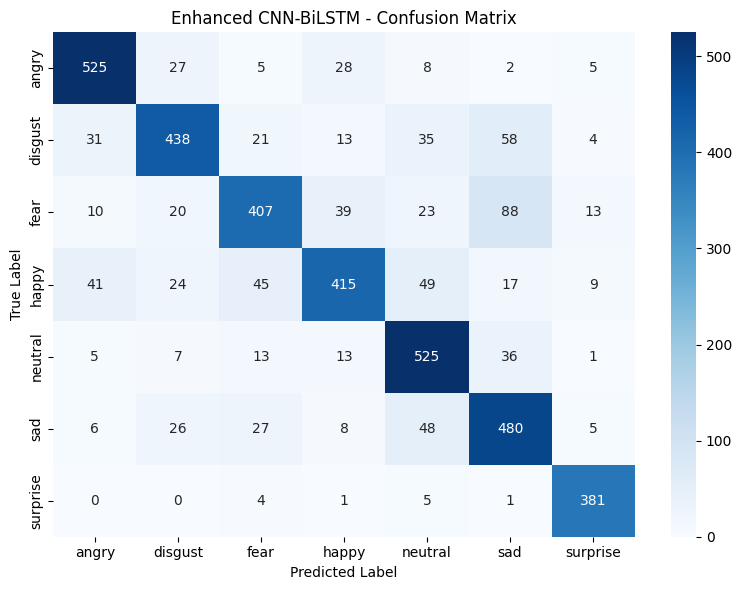

In [31]:
# Comprehensive model evaluation with precision, recall, and F1-score
def evaluate_model_comprehensive(model, test_loader, model_name):
    """
    Evaluate model with precision, recall, and F1-score metrics
    """
    model.eval()
    all_predictions = []
    all_targets = []
    test_loss = 0.0
    
    # Class weights for loss calculation
    class_counts = np.bincount(y_train)
    class_weights = torch.tensor(len(y_train) / (num_classes * class_counts), 
                                dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            
            _, predicted = outputs.max(1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    test_loss = test_loss / len(test_loader)
    test_accuracy = np.mean(np.array(all_predictions) == np.array(all_targets))
    
    # Calculate precision, recall, and F1-score
    precision, recall, f1, support = precision_recall_fscore_support(
        all_targets, all_predictions, average='weighted'
    )
    
    # Per-class metrics
    precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
        all_targets, all_predictions, average=None
    )
    
    print(f"\n{model_name} - Test Results:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall: {recall:.4f}")
    print(f"Weighted F1-Score: {f1:.4f}")
    
    # Per-class results
    print(f"\nPer-class metrics for {model_name}:")
    for i, emotion in enumerate(le.classes_):
        print(f"{emotion}: Precision={precision_per_class[i]:.4f}, "
              f"Recall={recall_per_class[i]:.4f}, F1={f1_per_class[i]:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(all_targets, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    return {
        'accuracy': test_accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'loss': test_loss,
        'predictions': all_predictions,
        'targets': all_targets
    }

# Evaluate all models
results = {}

print("Evaluating Enhanced 1D CNN model...")
results['1D_CNN'] = evaluate_model_comprehensive(model_1d_cnn, test_loader_1d, "Enhanced 1D CNN")

print("\nEvaluating Enhanced 2D CNN model...")
results['2D_CNN'] = evaluate_model_comprehensive(model_2d_cnn, test_loader_2d, "Enhanced 2D CNN")

print("\nEvaluating Enhanced CNN-BiLSTM model...")
results['CNN_BiLSTM'] = evaluate_model_comprehensive(model_cnn_bilstm, test_loader_1d, "Enhanced CNN-BiLSTM")


Evaluating Ensemble Model...

Ensemble Model Results:
Ensemble Accuracy: 0.8850
Ensemble Precision: 0.8875
Ensemble Recall: 0.8850
Ensemble F1-Score: 0.8845


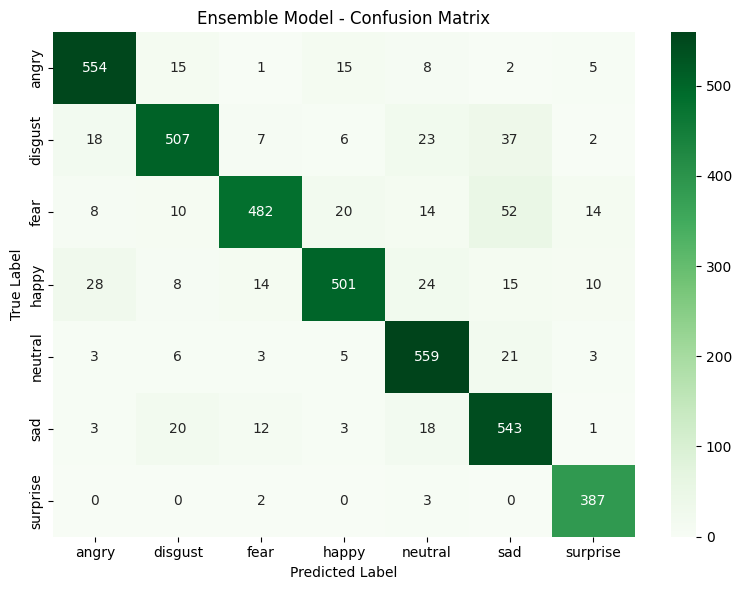

Ensemble model saved!


In [32]:
# Create ensemble model for improved performance
class EnsembleModel:
    def __init__(self, models, model_types, weights=None):
        self.models = models
        self.model_types = model_types
        
        if weights is None:
            # Equal weights
            self.weights = [1/len(models)] * len(models)
        else:
            # Normalize weights
            total = sum(weights)
            self.weights = [w/total for w in weights]
    
    def predict(self, inputs_1d, inputs_2d):
        """Make prediction using ensemble of models"""
        all_probs = []
        
        for i, (model, model_type) in enumerate(zip(self.models, self.model_types)):
            model.eval()
            with torch.no_grad():
                if model_type == '1d':
                    outputs = model(inputs_1d)
                else:  # '2d'
                    outputs = model(inputs_2d)
                
                probs = F.softmax(outputs, dim=1)
                weighted_probs = probs * self.weights[i]
                all_probs.append(weighted_probs)
        
        # Sum weighted probabilities
        ensemble_probs = sum(all_probs)
        _, predicted = ensemble_probs.max(1)
        
        return predicted, ensemble_probs

# Create ensemble based on validation accuracy
models = [model_1d_cnn, model_2d_cnn, model_cnn_bilstm]
model_types = ['1d', '2d', '1d']

# Calculate weights based on validation accuracy
val_accuracies = [
    max(history_1d_cnn['val_acc']),
    max(history_2d_cnn['val_acc']),
    max(history_cnn_bilstm['val_acc'])
]

# Create ensemble
ensemble = EnsembleModel(models, model_types, weights=val_accuracies)

# Evaluate ensemble
print("Evaluating Ensemble Model...")
ensemble_predictions = []
ensemble_targets = []

for (inputs_1d, targets_1d), (inputs_2d, _) in zip(test_loader_1d, test_loader_2d):
    inputs_1d = inputs_1d.to(device)
    inputs_2d = inputs_2d.to(device)
    targets = targets_1d.to(device)
    
    predicted, _ = ensemble.predict(inputs_1d, inputs_2d)
    
    ensemble_predictions.extend(predicted.cpu().numpy())
    ensemble_targets.extend(targets.cpu().numpy())

ensemble_accuracy = np.mean(np.array(ensemble_predictions) == np.array(ensemble_targets))

# Calculate ensemble metrics
ensemble_precision, ensemble_recall, ensemble_f1, _ = precision_recall_fscore_support(
    ensemble_targets, ensemble_predictions, average='weighted'
)

print(f"\nEnsemble Model Results:")
print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}")
print(f"Ensemble Precision: {ensemble_precision:.4f}")
print(f"Ensemble Recall: {ensemble_recall:.4f}")
print(f"Ensemble F1-Score: {ensemble_f1:.4f}")

# Ensemble confusion matrix
cm_ensemble = confusion_matrix(ensemble_targets, ensemble_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Ensemble Model - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Save ensemble model
torch.save({
    'model_1d_cnn': model_1d_cnn.state_dict(),
    'model_2d_cnn': model_2d_cnn.state_dict(),
    'model_cnn_bilstm': model_cnn_bilstm.state_dict(),
    'weights': ensemble.weights,
    'model_types': ensemble.model_types,
    'classes': le.classes_,
    'input_shape_1d': input_shape_1d,
    'input_shape_2d': input_shape_2d,
    'num_classes': num_classes
}, 'speech_emotion_ensemble_model.pth')

print("Ensemble model saved!")
